Maximum squared error: 0.295680


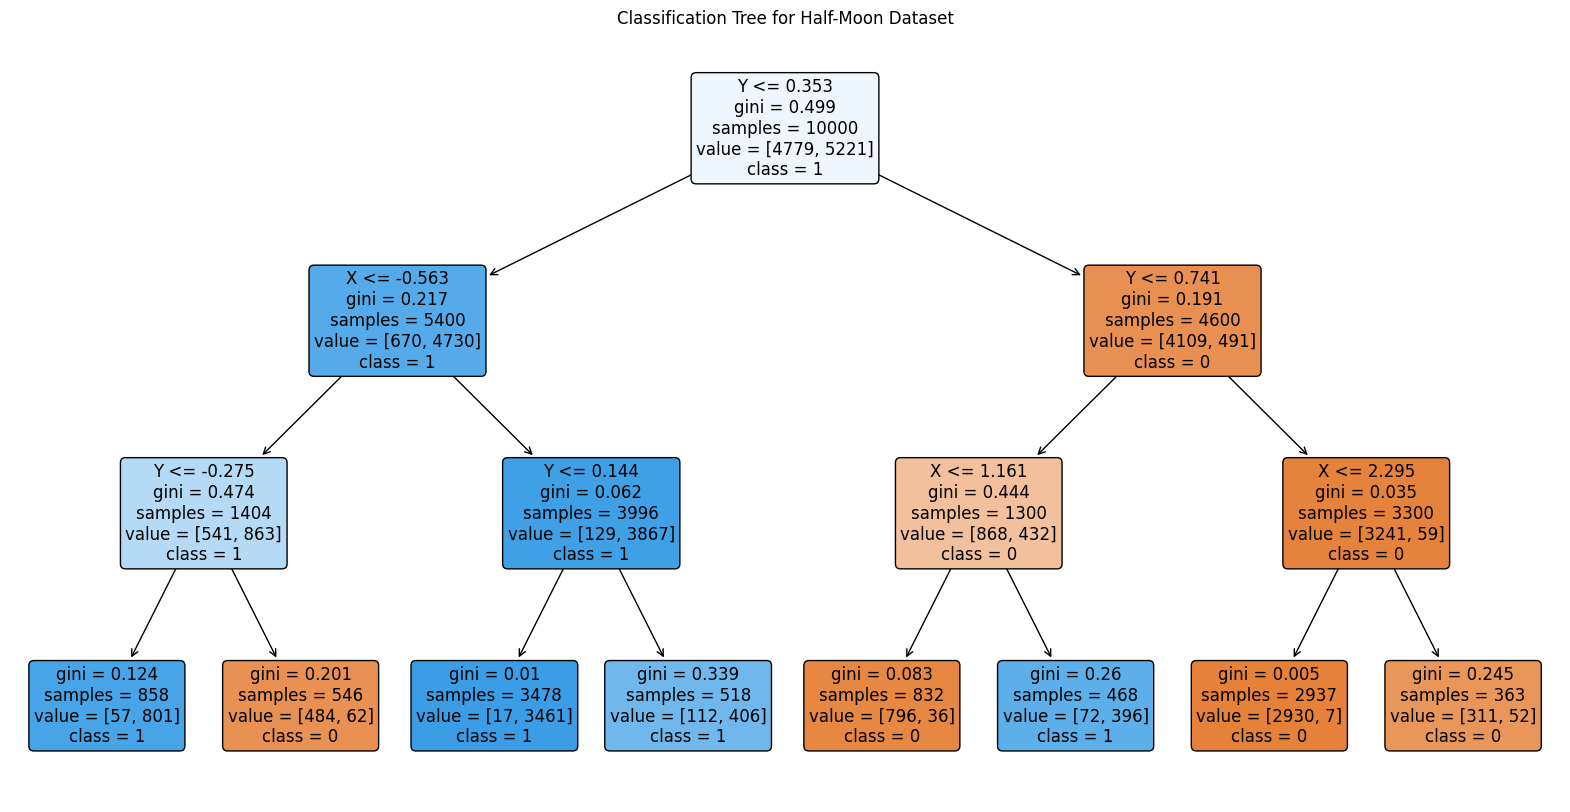

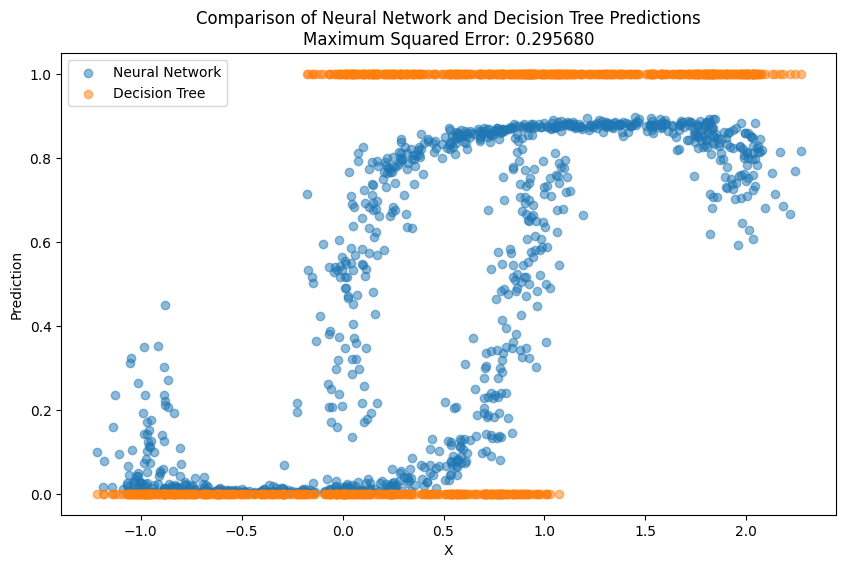

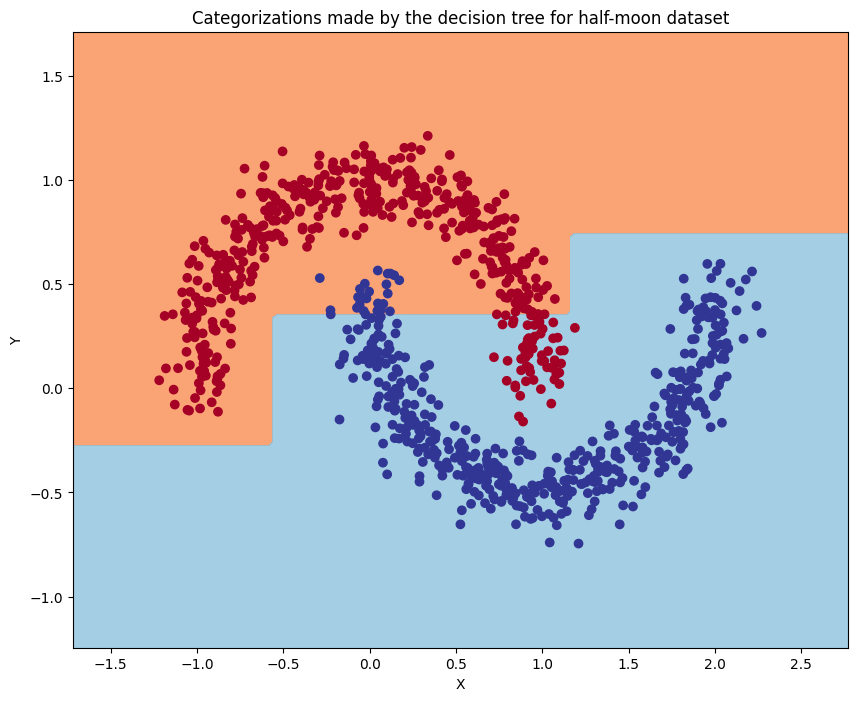

In [136]:
# Implementations of "Neural Networks are decision trees"
# https://arxiv.org/pdf/2210.05189
# © Jaward Sesay

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeClassifier, plot_tree

X, y = make_moons(n_samples=1000, noise=0.1, random_state=42)
X = torch.FloatTensor(X).to(torch.float32)
y = torch.FloatTensor(y).to(torch.float32)

# simple nn
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(2, 2) # input layer
        self.fc2 = nn.Linear(2, 2) # hidden layer
        self.fc3 = nn.Linear(2, 1) # output layer
        self.leaky_relu = nn.LeakyReLU(0.3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# init nn
net = NN()
net = net.to(torch.float32)

# loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters())

# train nn for 1k epoc
for epoch in range(1000):
    optimizer.zero_grad()
    outputs = net(X)
    loss = criterion(outputs, y.unsqueeze(1))
    loss.backward()
    optimizer.step()

# save state_dict
torch.save(net.state_dict(), 'state_dict.pth')

# load state_dict
net.load_state_dict(torch.load('state_dict.pth'))
net.eval()

# generate predictions
with torch.no_grad():
    y_pred = net(X).squeeze().numpy()

# grids for makemoons categorizations plot
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))
grid = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]).to(torch.float32)

with torch.no_grad():
    y_pred_grid = net(grid).squeeze().numpy()

# extract decision tree from nn
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(grid.numpy(), y_pred_grid > 0.5)

# calculate mse
mse = np.max(np.square(y_pred - dt.predict_proba(X.numpy())[:, 1]))
print(f'Maximum squared error: {mse:.6f}')

# visualize decision tree
plt.figure(figsize=(20, 10))
plot_tree(dt, filled=True, rounded=True, feature_names=['X', 'Y'], class_names=['0', '1'], fontsize=12)
plt.title("Classification Tree for Half-Moon Dataset")
plt.show()

# comparison plot
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], y_pred, label='Neural Network', alpha=0.5)
plt.scatter(X[:, 0], dt.predict(X.numpy()), label='Decision Tree', alpha=0.5)
plt.title(f'Comparison of Neural Network and Decision Tree Predictions\nMaximum Squared Error: {mse:.6f}')
plt.legend()
plt.xlabel('X')
plt.ylabel('Prediction')
plt.show()

# makemoons categorizations plot
Z = dt.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.title("Categorizations made by the decision tree for half-moon dataset")
plt.xlabel('X')
plt.ylabel('Y')
plt.show()